In [1]:
import pandas as pd, numpy as np, os
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
output_dir ='/ihme/costeffectiveness/results/vivarium_ciff_sam/v5.3.3_sam_k_sensitivity/ciff_sam/2022_02_08_09_51_56/count_data/'

In [3]:
pd.read_csv(output_dir + 'wasting_transition_count.csv').age.unique()

array(['early_neonatal', 'late_neonatal', '1-5_months', '6-11_months',
       '12_to_23_months', '2_to_4'], dtype=object)

In [4]:
def calculate_wasting_values(output_dir, ages, strata_cols, measure, metric, 
                             relative_scenario):
    if measure=='prevalence':
        data = pd.read_csv(output_dir + 'wasting_state_person_time.csv').drop(columns=['Unnamed: 0'])
        data = data.loc[data.year!=2022]
        wasted = data.loc[data.cause.str.contains('acute_malnutrition')]
        wasted['cause'] = 'wasted'
        wasted = (wasted.groupby([c for c in wasted.columns if c != 'value']).sum())
        data = pd.concat([data,wasted.reset_index()],ignore_index=True)
    elif measure=='incidence':
        data = (pd.read_csv(output_dir + 'wasting_transition_count.csv')
                .drop(columns=['Unnamed: 0']).rename(columns={'measure':'cause'}))
        data = data.loc[data.year!=2022]
        wasted = data.loc[data.cause.isin(['mild_child_wasting_to_moderate_acute_malnutrition_event_count',
                                          'moderate_acute_malnutrition_to_severe_acute_malnutrition_event_count'])]
        wasted['cause'] = 'wasted'
        total_mam = data.loc[data.cause.isin(['mild_child_wasting_to_moderate_acute_malnutrition_event_count',
                                             'severe_acute_malnutrition_to_moderate_acute_malnutrition_event_count'])]
        total_mam['cause'] = 'total_mam'
        wasted = pd.concat([wasted,total_mam])
        wasted = (wasted.groupby([c for c in wasted.columns if c != 'value']).sum())
        data = pd.concat([data,wasted.reset_index()],ignore_index=True)
        pt = pd.read_csv(output_dir + 'wasting_state_person_time.csv').drop(columns=['Unnamed: 0'])
        pt = pt.loc[pt.year!=2022]
    groupby_cols = ['input_draw','scenario','cause']
    data = data.loc[data.age.isin(ages)]    
    if 'year' in strata_cols:
        t = data.loc[(data.year==2023)&(data.scenario=='baseline')]
        t['year'] = 2022
        for i in data.scenario.unique():
            t['scenario'] = i
            data = pd.concat([data,t])   
        if measure=='incidence':
            t = pt.loc[(pt.year==2023)&(pt.scenario=='baseline')]
            t['year'] = 2022
            for i in data.scenario.unique():
                t['scenario'] = i
                pt = pd.concat([pt,t])
    data = data.groupby(['input_draw','scenario'] + strata_cols + ['cause']).sum()
    if measure=='prevalence':
        data = data / data.groupby(['input_draw','scenario'] + strata_cols).sum() * 100
    else:
        pt = pt.loc[pt.age.isin(ages)].groupby(['input_draw','scenario'] + strata_cols).sum()
        data = data / pt * 100_000     
    if metric=='value':
        data = (data.groupby(['scenario','cause'] + strata_cols)
                    .describe(percentiles=[0.025,0.975]))
    else:
        data_baseline = (data.reset_index().loc[data.reset_index().scenario==relative_scenario]
                   .set_index(['input_draw','cause'] + strata_cols)
                   .drop(columns='scenario'))
        if metric=='percent_reduction':
            data = ((data_baseline - data.reset_index().set_index(['input_draw','cause'] + strata_cols + ['scenario']))
                    / data_baseline) * 100
        elif metric=='absolute_reduction':
            data = data_baseline - data.reset_index().set_index(['input_draw','cause'] + strata_cols + ['scenario'])
            
        data = (data.reset_index().groupby(['scenario','cause'] + strata_cols)
                .describe(percentiles=[0.025,0.975])).drop(columns='input_draw')
    return data[['value']].reset_index()

In [5]:
six_to_59_ages = ['6-11_months',
       '12_to_23_months', '2_to_4']
ages = ['6-11_months',
       '12_to_23_months', '2_to_4']

In [6]:
pt = pd.read_csv(output_dir + 'wasting_state_person_time.csv').drop(columns=['Unnamed: 0'])
pt = pt.loc[pt.age.isin(ages)]

trans = pd.read_csv(output_dir + 'wasting_transition_count.csv').drop(columns=['Unnamed: 0'])
trans = trans.loc[trans.age.isin(ages)]
trans['cause'] = (trans.measure
                  .str.replace('susceptible_to_child_wasting','tmrel')
                  .str.split('_to_',expand=True)[1]
                  .str.split('_event_count',expand=True)[0]
                  .str.replace('tmrel','susceptible_to_child_wasting'))
cols = ['input_draw','scenario','sam_k','cause','year']
data = (pt.groupby(cols).sum() / trans.groupby(cols).sum() * 365).reset_index()
data = data.loc[data.year==2026].groupby(['cause','sam_k','scenario']).describe(percentiles=[0.025,0.975])['value']
data

count  \
cause                        sam_k       scenario                     
mild_child_wasting           alternative baseline              12.0   
                                         lbwsg_interventions   12.0   
                                         sqlns                 12.0   
                                         wasting_treatment     12.0   
                             baseline    baseline              12.0   
                                         lbwsg_interventions   12.0   
                                         sqlns                 12.0   
                                         wasting_treatment     12.0   
moderate_acute_malnutrition  alternative baseline              12.0   
                                         lbwsg_interventions   12.0   
                                         sqlns                 12.0   
                                         wasting_treatment     12.0   
                             baseline    baseline              12.0   
                                         lbwsg_interventions   12.0   
                                         sqlns                 12.0   
                                         wasting_treatment     12.0   
severe_acute_malnutrition    alternative baseline              12.0   
                                         lbwsg_interventions   12.0   
                                         sqlns                 12.0   
                                         wasting_treatment     12.0   
                             baseline    baseline              12.0   
                                         lbwsg_interventions   12.0   
                                         sqlns                 12.0   
                                         wasting_treatment     12.0   
susceptible_to_child_wasting alternative baseline              12.0   
                                         lbwsg_interventions   12.0   
                                         sqlns                 12.0   
                                         wasting_treatment     12.0   
                             baseline    baseline              12.0   
                                         lbwsg_interventions   12.0   
                                         sqlns                 12.0   
                                         wasting_treatment     12.0   

                                                                    mean  \
cause                        sam_k       scenario                          
mild_child_wasting           alternative baseline              25.238324   
                                         lbwsg_interventions   25.820167   
                                         sqlns                 25.820904   
                                         wasting_treatment     25.210173   
                             baseline    baseline              25.240382   
                                         lbwsg_interventions   25.820950   
                                         sqlns                 25.820366   
                                         wasting_treatment     25.211348   
moderate_acute_malnutrition  alternative baseline              54.065367   
                                         lbwsg_interventions   46.138101   
                                         sqlns                 46.118805   
                                         wasting_treatment     45.789066   
                             baseline    baseline              48.840429   
                                         lbwsg_interventions   42.226964   
                                         sqlns                 42.216679   
                                         wasting_treatment     42.003626   
severe_acute_malnutrition    alternative baseline             114.354556   
                                         lbwsg_interventions   91.262625   
                                         sqlns                 91.172473   
                                         wasting_tr

## Finding 1: cross sectional prevalence

<ipython-input-4-d3a7b7ba466c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wasted['cause'] = 'wasted'
<ipython-input-4-d3a7b7ba466c>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['year'] = 2022
<ipython-input-4-d3a7b7ba466c>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

Text(1.5, 2.7, 'Simulated intervention impacts on acute malnutrition\ncross-sectional exposure among children six to 59 months\n(with 95% uncertainty intervals)')

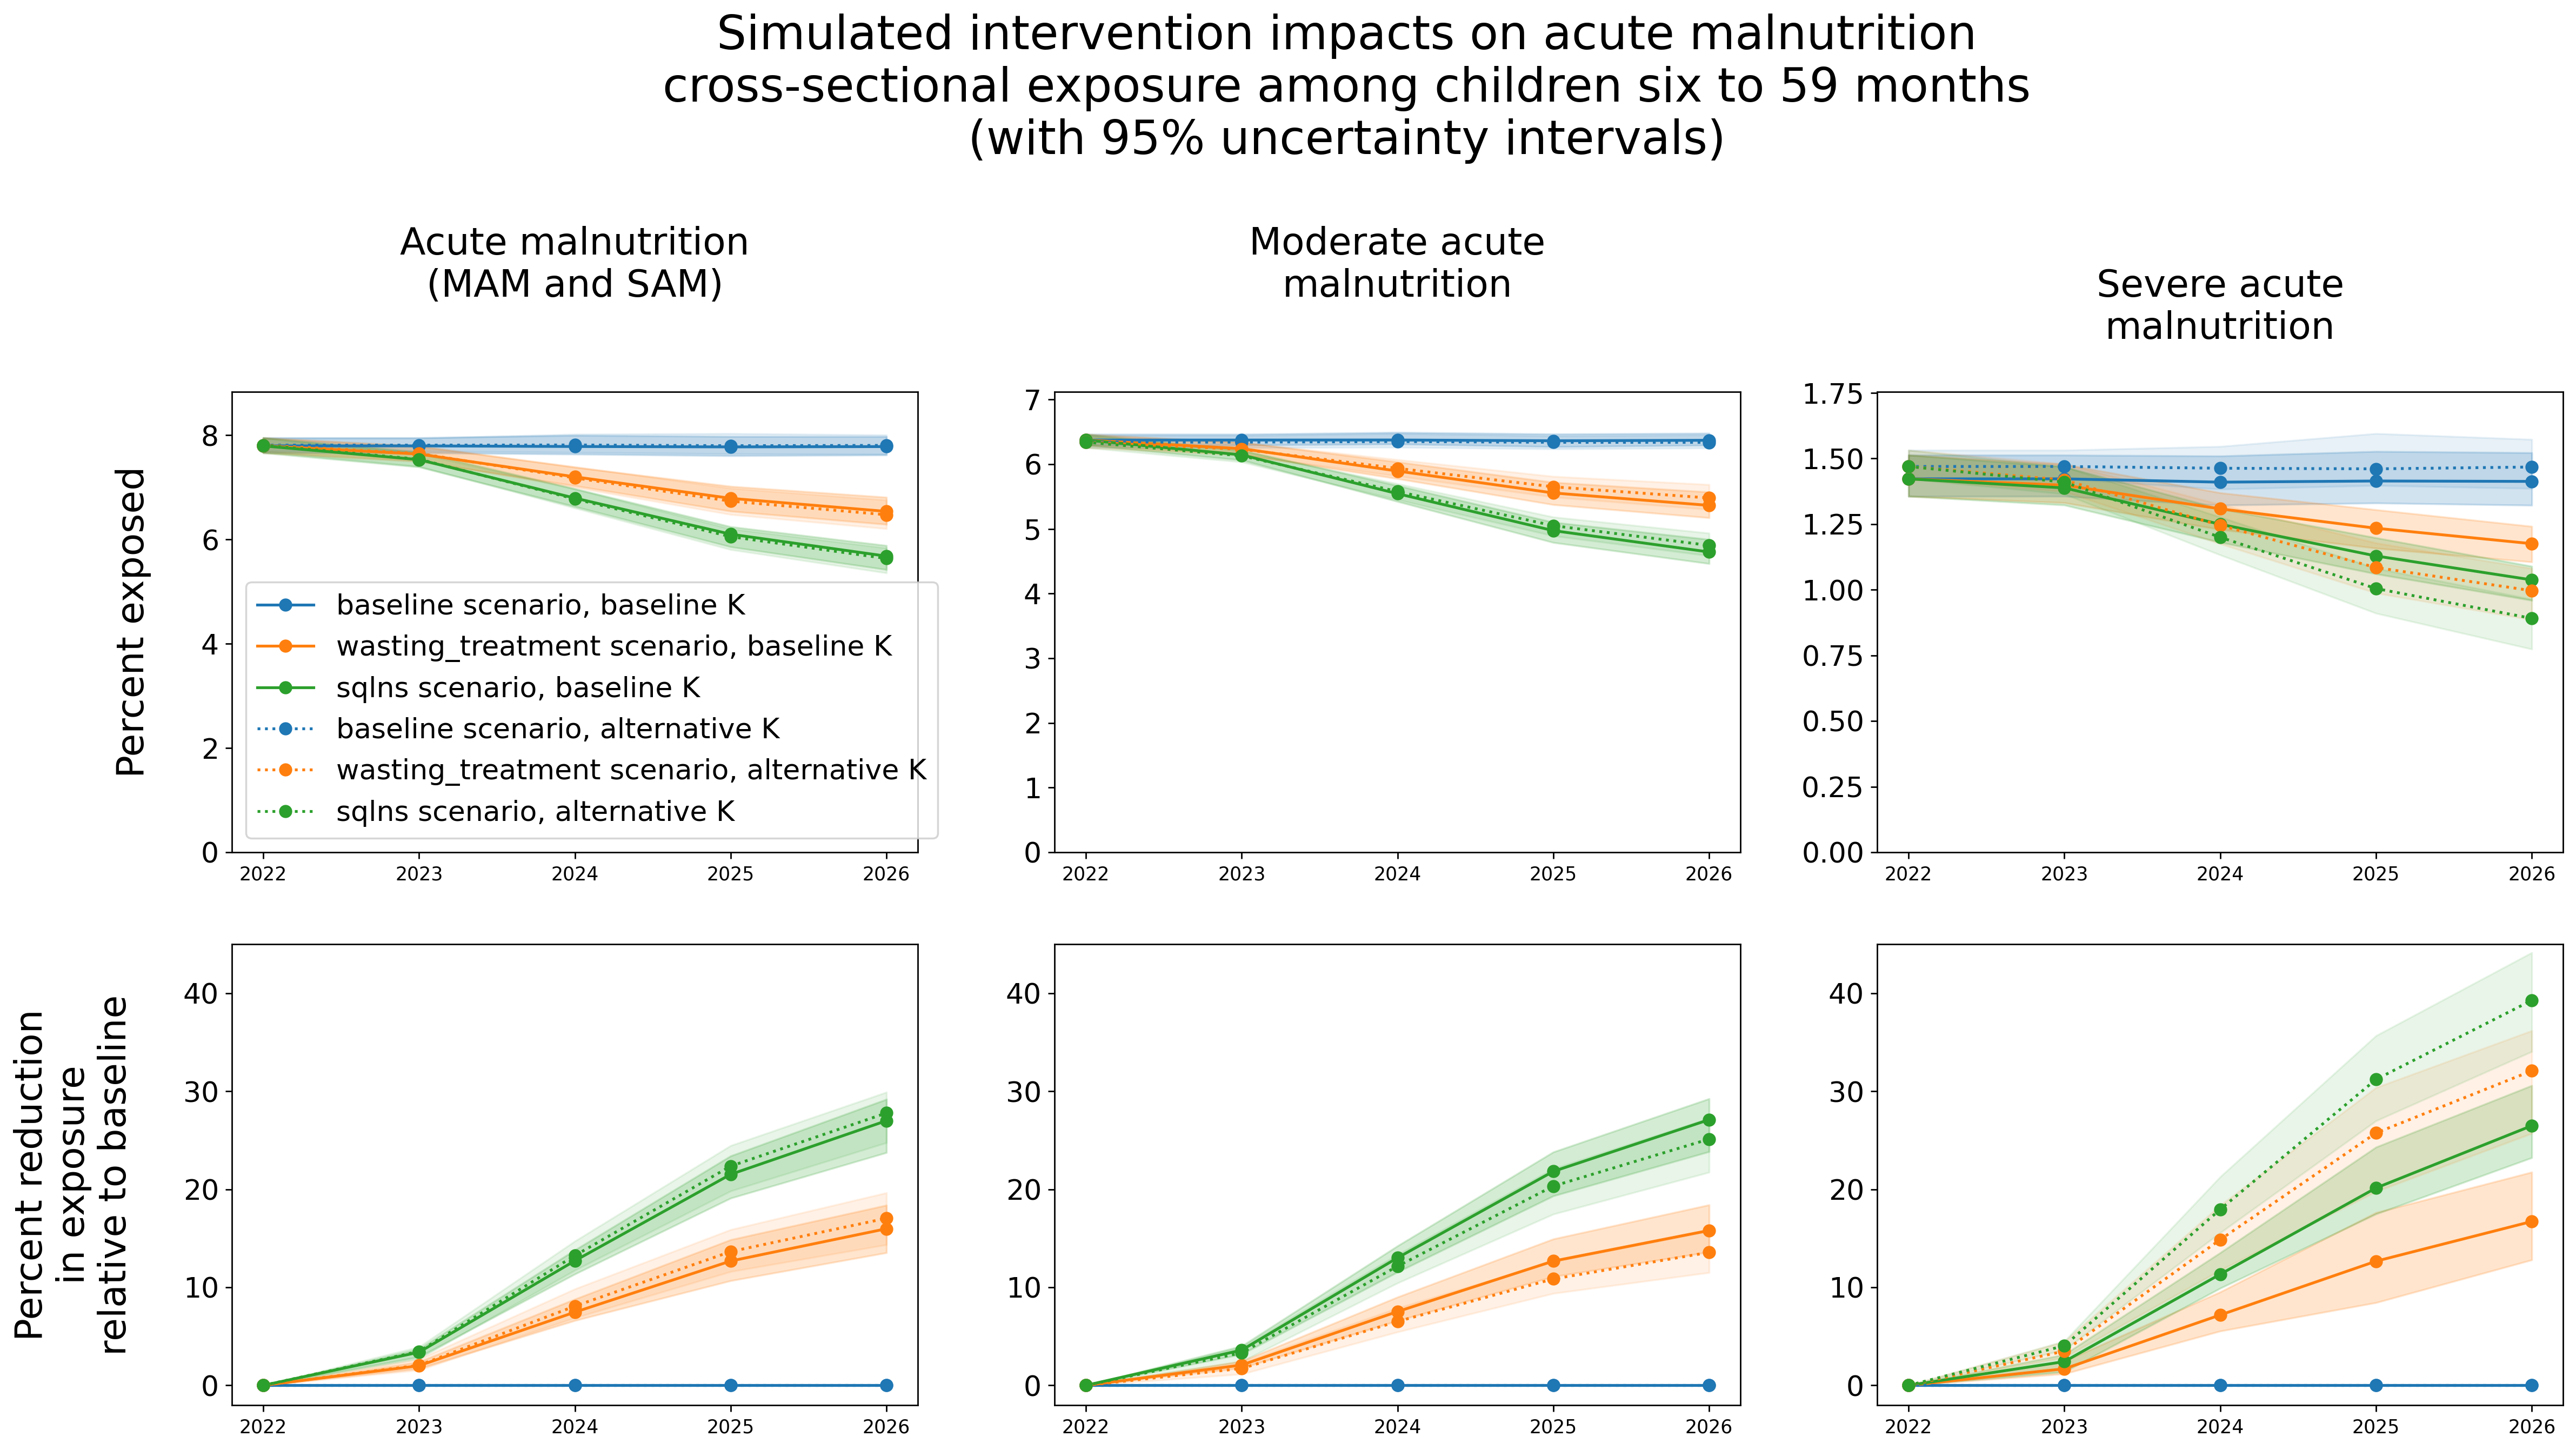

In [7]:
causes = ['wasted','moderate_acute_malnutrition','severe_acute_malnutrition']
cause_titles = ['Acute malnutrition\n(MAM and SAM)\n\n',
               'Moderate acute\nmalnutrition\n\n',
               'Severe acute\nmalnutrition\n']
metrics = ['value','percent_reduction']

fig, axs = plt.subplots(len(metrics), len(causes),dpi=250)
for metric in metrics:
    data = calculate_wasting_values(output_dir, six_to_59_ages, ['sam_k','year'], 
                                        'prevalence', 
                                        metric, 
                                        'baseline')
    for k in ['baseline','alternative']:
        for cause in causes:
            p = data.loc[(data.cause==cause)&(data.sam_k==k)]
            pos = axs[metrics.index(metric),causes.index(cause)]   
            for i in ['baseline','wasting_treatment','sqlns']:
                p_sub = p.loc[p.scenario==i]
                if i =='baseline':
                    color = 'tab:blue'
                elif i == 'wasting_treatment':
                    color='tab:orange'
                else:
                    color='tab:green'
                if k == 'baseline':
                    linestyle='solid'
                    alpha=0.2
                else:
                    linestyle='dotted'
                    alpha=0.1
                pos.plot(p_sub['year'], p_sub['value','mean'], marker='o', label=f'{i} scenario, {k} K',
                        c = color, linestyle=linestyle)
                pos.fill_between(p_sub['year'], p_sub['value','2.5%'], p_sub['value','97.5%'], alpha=alpha, color=color)
            pos.grid()
            pos.set_xticks(p_sub.year.unique())
            #pos.set_xticklabels(p_sub.year.unique(),Fontsize=15)
            pos.tick_params(axis='y', labelsize=15)
            if metrics.index(metric)==0:
                pos.set_ylim(0,p.loc[p.scenario=='baseline']['value','97.5%'].max()*1.1)
                pos.set_title(cause_titles[causes.index(cause)],size=20)
                if causes.index(cause)==0:
                    pos.set_ylabel('Percent exposed\n',size=20)
                    pos.legend(#['Baseline','Alternative scenario 1','Alternative scenario 2'], 
                           fontsize=15)
            if metric=='percent_reduction':
                pos.set_ylim(-2,45)
                if causes.index(cause)==0:
                    pos.set_ylabel('Percent reduction\nin exposure\nrelative to baseline\n',size=20)
            pos.grid()
plt.subplots_adjust(right=len(causes), top=len(metrics))
#plt.legend(['Baseline','Alternative scenario 1','Alternative scenario 2'], bbox_to_anchor=[0.25,4.15], fontsize=20)
plt.suptitle('Simulated intervention impacts on acute malnutrition\ncross-sectional exposure among children six to 59 months\n(with 95% uncertainty intervals)',
             y=2.7,x=1.5,size=25)


# Finding 2: incidence

<ipython-input-4-d3a7b7ba466c>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wasted['cause'] = 'wasted'
<ipython-input-4-d3a7b7ba466c>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_mam['cause'] = 'total_mam'
<ipython-input-4-d3a7b7ba466c>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

Text(1, 3.5, 'Simulated intervention impacts on acute malnutrition\nincidence rates among children six to 59 months\n(with 95% uncertainty intervals)')

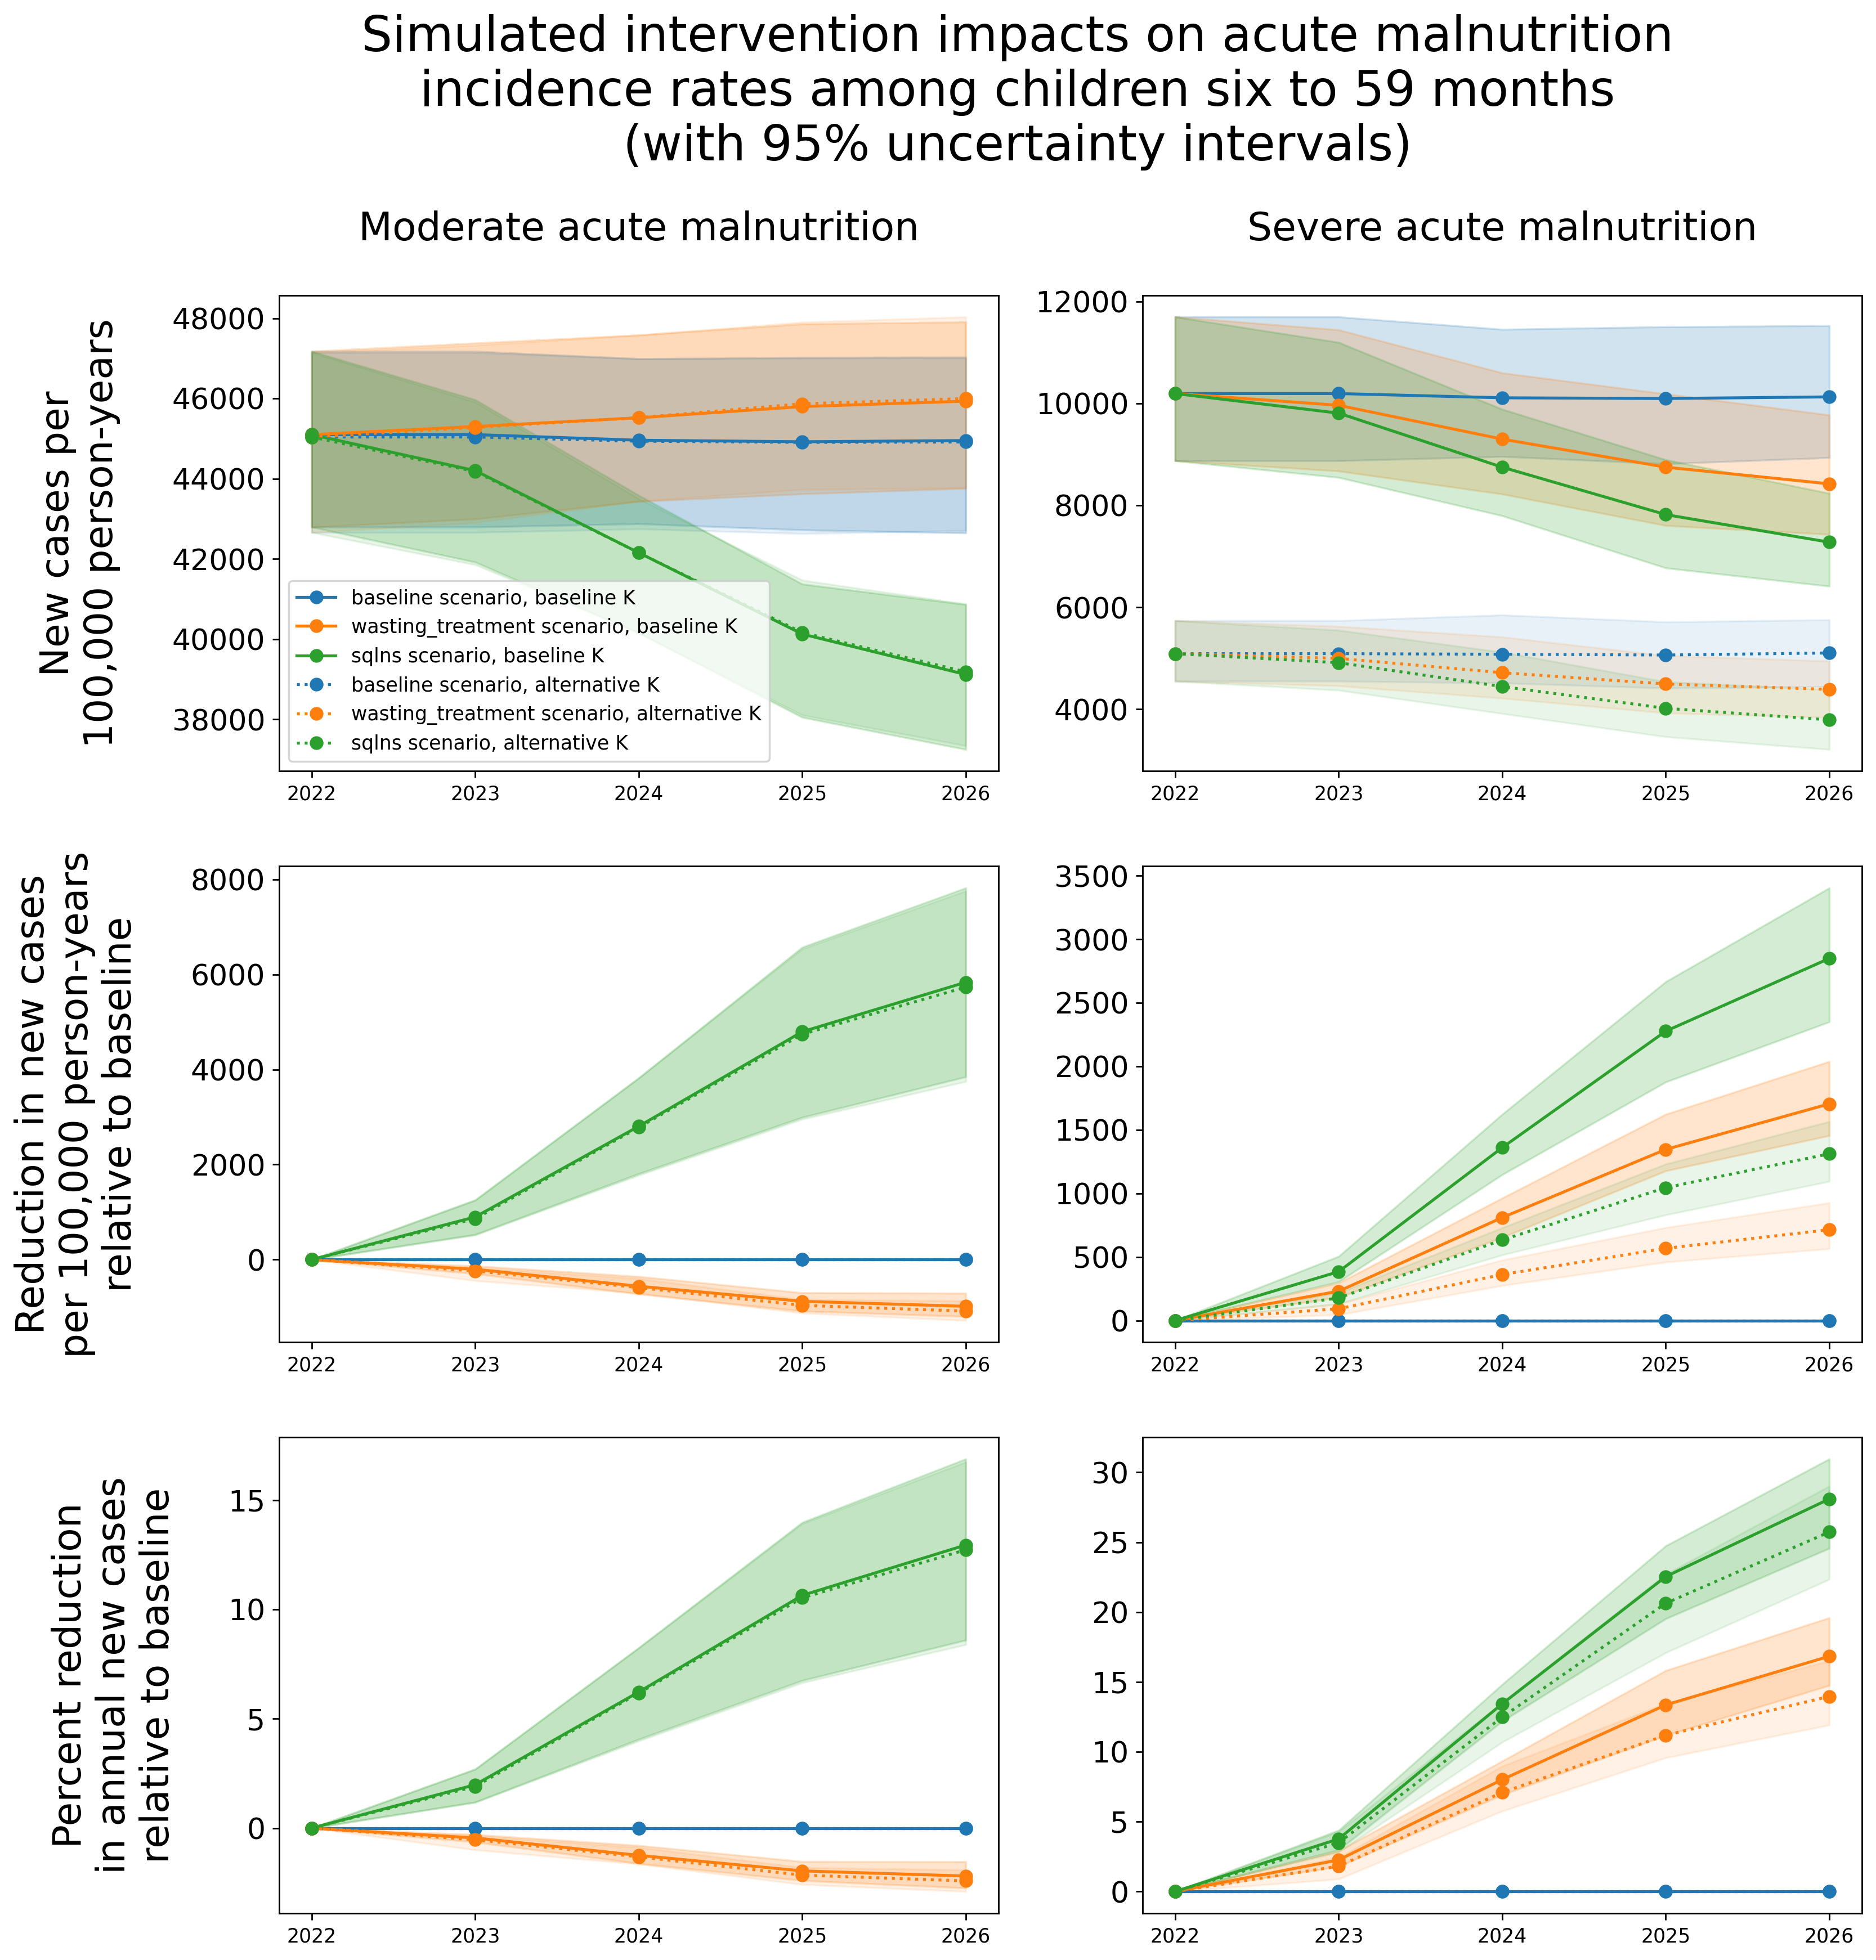

In [8]:
causes = ['mild_child_wasting_to_moderate_acute_malnutrition_event_count',
          'moderate_acute_malnutrition_to_severe_acute_malnutrition_event_count',
          #'total_mam',
          #'moderate_acute_malnutrition_to_severe_acute_malnutrition_event_count'
         ]

cause_titles = ['Moderate acute malnutrition\n',
                'Severe acute malnutrition\n',
                #'All transitions\ninto MAM\n',
                #'MAM cases from\nspontaneous\nSAM recovery'
               ]
metrics = ['value','absolute_reduction','percent_reduction']
metric_titles=['New cases per\n100,000 person-years\n',
              'Reduction in new cases\nper 100,000 person-years\nrelative to baseline\n',
              'Percent reduction\nin annual new cases\nrelative to baseline\n']

fig, axs = plt.subplots(len(metrics), len(causes),dpi=250)
for metric in metrics:
    data = calculate_wasting_values(output_dir, six_to_59_ages, ['sam_k','year'], 
                                        'incidence', 
                                        metric, 
                                  'baseline')
    for k in ['baseline','alternative']:
        for cause in causes:
            p = data.loc[(data.cause==cause)&(data.sam_k==k)]
            pos = axs[metrics.index(metric),causes.index(cause)]   
            for i in ['baseline','wasting_treatment','sqlns']:
                p_sub = p.loc[p.scenario==i]
                if i =='baseline':
                    color = 'tab:blue'
                elif i == 'wasting_treatment':
                    color='tab:orange'
                else:
                    color='tab:green'
                if k == 'baseline':
                    linestyle='solid'
                    alpha=0.2
                else:
                    linestyle='dotted'
                    alpha=0.1
                pos.plot(p_sub['year'], p_sub['value','mean'], marker='o', label=f'{i} scenario, {k} K',
                        c = color, linestyle=linestyle)
                pos.fill_between(p_sub['year'], p_sub['value','2.5%'], p_sub['value','97.5%'], alpha=alpha, color=color)
            pos.grid()
            pos.set_xticks(p_sub.year.unique())
            pos.set_xticklabels(p_sub.year.unique())#,Fontsize=15)
            pos.tick_params(axis='y', labelsize=15)
            if causes.index(cause)==0:
                pos.set_ylabel(metric_titles[metrics.index(metric)],size=20)
                if metrics.index(metric)==0:
                    pos.legend(#['Baseline','Alternative scenario 1','Alternative scenario 2'],
                          #bbox_to_anchor=[0.25,4.15], 
                          # fontsize=15
                    )
            if metrics.index(metric)==0:
                pos.set_title(cause_titles[causes.index(cause)],size=20)
                #pos.set_ylim(0,p.loc[p.scenario=='baseline']['value','97.5%'].max()*1.1)
            
plt.subplots_adjust(right=len(causes), top=len(metrics))
#plt.legend(['Baseline','Alternative scenario 1','Alternative scenario 2'], bbox_to_anchor=[0.25,4.15], fontsize=20)
plt.suptitle('Simulated intervention impacts on acute malnutrition\nincidence rates among children six to 59 months\n(with 95% uncertainty intervals)',
             y=len(metrics)+.5,x=1,size=25)

# Finding 3: relative to alternative scenario 1

<ipython-input-4-d3a7b7ba466c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wasted['cause'] = 'wasted'
<ipython-input-4-d3a7b7ba466c>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['year'] = 2022
<ipython-input-4-d3a7b7ba466c>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

Text(1.5, 2.75, 'Simulated intervention impacts on acute\nmalnutrition cross-sectional exposure among children six to\n59 months relative to alternative scenario 1\n(with 95% uncertainty intervals)')

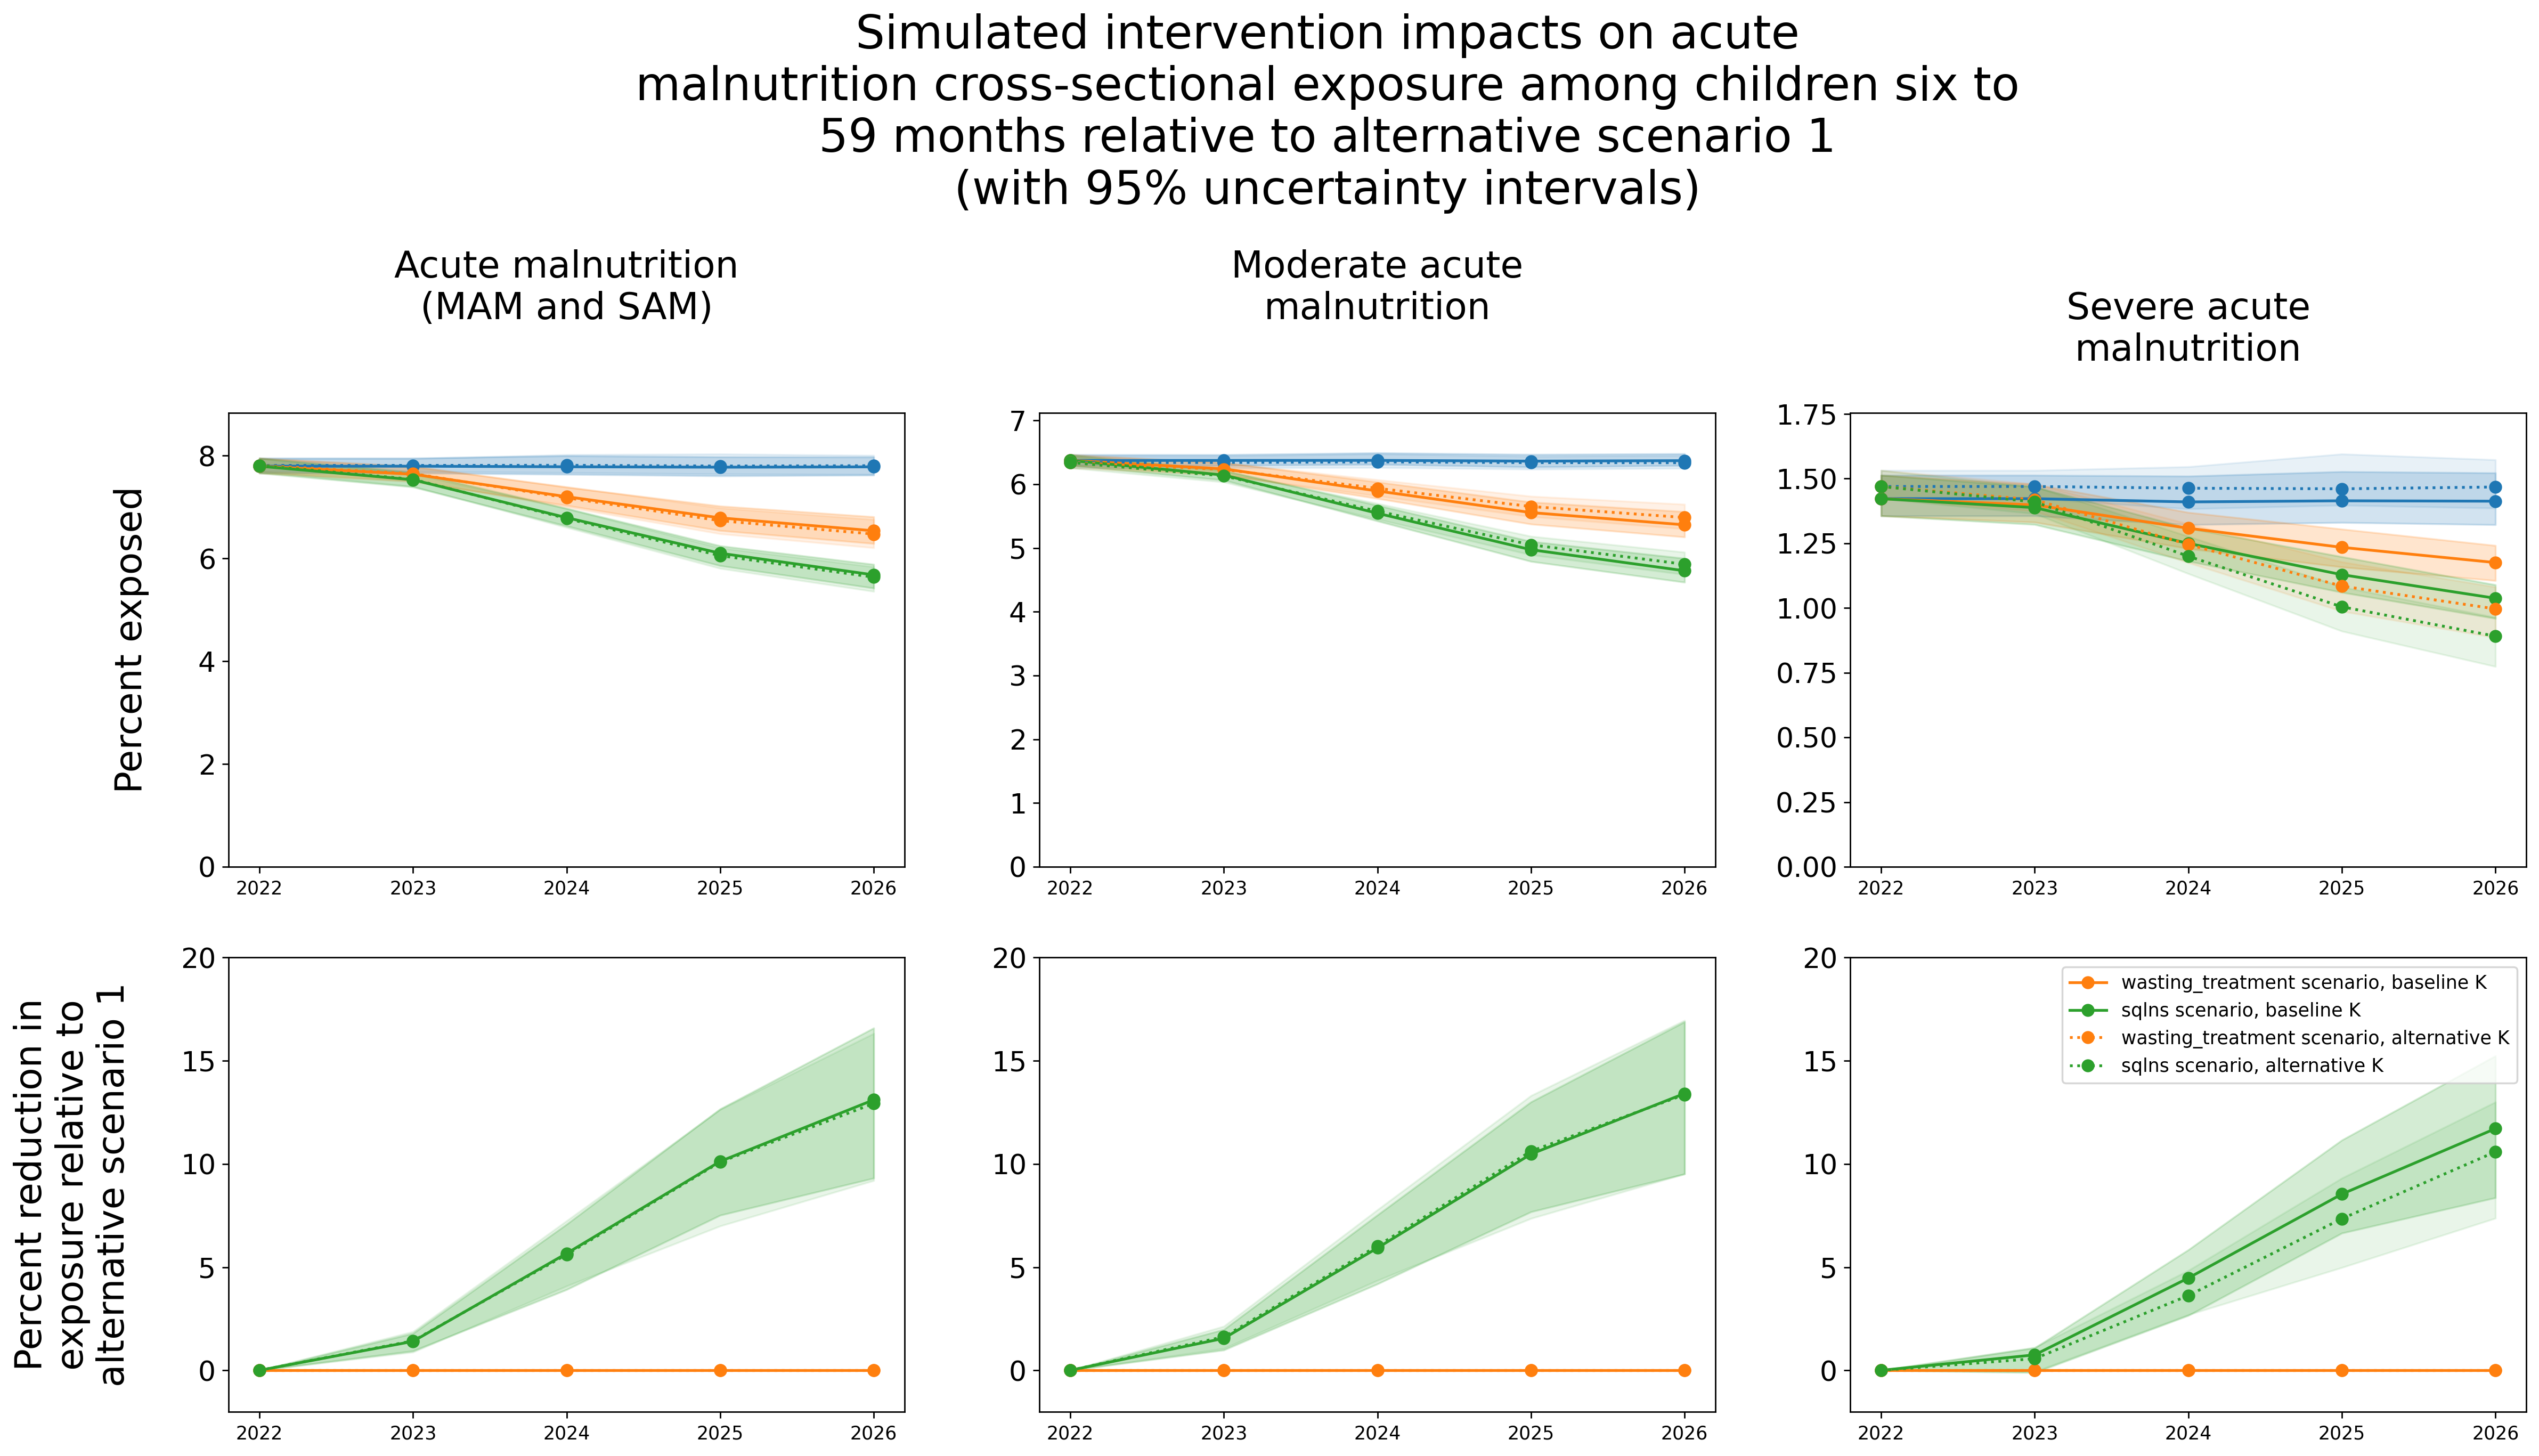

In [14]:
causes = ['wasted','moderate_acute_malnutrition','severe_acute_malnutrition']
cause_titles = ['Acute malnutrition\n(MAM and SAM)\n\n',
               'Moderate acute\nmalnutrition\n\n',
               'Severe acute\nmalnutrition\n']
metrics = ['value','percent_reduction']

fig, axs = plt.subplots(len(metrics), len(causes),dpi=250)
for metric in metrics:
    data = calculate_wasting_values(output_dir, six_to_59_ages, ['sam_k','year'], 
                                        'prevalence', 
                                        metric, 
                                        'wasting_treatment')
    for k in ['baseline','alternative']:
        for cause in causes:
            p = data.loc[(data.cause==cause)&(data.sam_k==k)]
            pos = axs[metrics.index(metric),causes.index(cause)]  
            if metric=='value':
                scenarios = ['baseline','wasting_treatment','sqlns']
            else:
                scenarios = ['wasting_treatment','sqlns']
            for i in scenarios:
                p_sub = p.loc[p.scenario==i]
                
                if i =='baseline':
                    color = 'tab:blue'
                elif i == 'wasting_treatment':
                    color='tab:orange'
                else:
                    color='tab:green'
                if k == 'baseline':
                    linestyle='solid'
                    alpha=0.2
                else:
                    linestyle='dotted'
                    alpha=0.1
                pos.plot(p_sub['year'], p_sub['value','mean'], marker='o', label=f'{i} scenario, {k} K',
                        c = color, linestyle=linestyle)
                pos.fill_between(p_sub['year'], p_sub['value','2.5%'], p_sub['value','97.5%'], alpha=alpha, color=color)
            pos.grid()
            pos.set_xticks(p_sub.year.unique())
            pos.set_xticklabels(p_sub.year.unique())
            pos.tick_params(axis='y', labelsize=15)
            if metric=='value':
                pos.set_ylim(0,p.loc[p.scenario=='baseline']['value','97.5%'].max()*1.1)
                pos.set_title(cause_titles[causes.index(cause)],size=20)
                if causes.index(cause)==0:
                    pos.set_ylabel('Percent exposed\n',size=20)
                    #pos.legend(['Baseline','Alternative scenario 1','Alternative scenario 2'], 
                    #       fontsize=15)
            if metric=='percent_reduction':
                pos.set_ylim(-2,20)
                if causes.index(cause)==0:
                    pos.set_ylabel('Percent reduction in\nexposure relative to\nalternative scenario 1\n',size=20)

plt.subplots_adjust(right=len(causes), top=len(metrics))
plt.legend()#bbox_to_anchor=[0.25,4.15], fontsize=20)
plt.suptitle('Simulated intervention impacts on acute\nmalnutrition cross-sectional exposure among children six to\n59 months relative to alternative scenario 1\n(with 95% uncertainty intervals)',
             y=2.75,x=1.5,size=25)